In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT

# for creating custom gates
from qiskit import quantum_info as qi

# import basic plot tools
from qiskit.visualization import plot_histogram

# for simulation
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram, plot_state_city


# blochsphere for debugging hopefully
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector


In [2]:
#edge weights

w_1 = 4 # a <-> b
w_2 = 2 # a <-> c
w_3 = 4 # a <-> d
w_4 = 4 # b <-> c
w_5 = 5 # c <-> d
w_6 = 6 # b <-> d

weights = []

for i in range(1, 7):
    variable_name = "w_" + str(i)
    current_number = locals()[variable_name]
    weights.append(current_number)

#sorting edge weights
sorted_weights = np.sort(weights)[::-1]

# normalization factor
S = np.sum(sorted_weights[:4])

# epsilon
eps = 1

weights = weights / (S + eps)
weights

array([0.2 , 0.1 , 0.2 , 0.2 , 0.25, 0.3 ])

In [3]:
## solutions

# A->B->C->D->A
# A->B->D->C->A 
# A->C->B->D->A

print('solution 1: {:.2f}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0] + weights[5] + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[5] + weights[2]))
print(" ")
print('solutions after max weight removed')
print('solution 1: {:.2f}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0]  + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[2]))

solution 1: 0.85
solution 2: 0.85
solution 3: 0.8
 
solutions after max weight removed
solution 1: 0.85
solution 2: 0.55
solution 3: 0.5


In [4]:
## Creating CU matrix

m = 8                                              # eigenvalue qubits
U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[5] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(U) != 0))                    # confirming only the diagonal is being used.

Ugate = qi.Operator(U).to_instruction()
Ugate.label = "CU"
CUgate = Ugate.control()

True


In [5]:
## confirming the eigenstates are correct

eigstatelist = ['01101100', #1230 A->B->C->D->A
                '01110010', #1302 A->B->D->C->A 
                '10110100'] #2310 A->C->B->D->A

U_angles = np.diag(np.angle(U))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]

# converting from (-pi,pi) to (0,2pi)
sol_check = U_angles[eiglistint] + 1
sol_check

array([0.85, 0.85, 0.8 ])

In [6]:
### creating CU

max_index = np.where(weights == 0.3)[0][0] ## removing edgeweight value 6 (normalized val = 0.3)
weights[max_index] = 0                                 

U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])

U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[5] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])

U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])

U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])

## tensor product all of them
## Add ones to the diagonal (first half)

Up = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(Up) != 0))# confirming only the diagonal is being used.

UPgate = qi.Operator(Up).to_instruction()
UPgate.label = "CU'"
CUPgate = UPgate.control()

True


In [7]:
U_angles = np.diag(np.angle(Up))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]

# converting from (-pi,pi) to (0,2pi)
sol_check = U_angles[eiglistint] + 1
sol_check[2] -= 1
sol_check

array([0.85, 0.55, 0.5 ])

In [8]:
# Single Cycle Representation

def bitstring_converter(string):
    values = []
    value = 0
    j = 0
    for i, v in enumerate(string):
        if v == '1':
            value += 1/(2**(i+1-j))
        elif v == " ":
            values.append(value)
            value = 0
            j = i+1
        if i == len(string)-1:
            values.append(value)
    return values[::-1]



def SingleHamiltonianCycle(eig, n):
    # we need a register for the eigenstate:
    eigst   = QuantumRegister(m, name = 'eigenstate')
    
    # we need two registers for the constrained problem:
    phase   = QuantumRegister(n, name = 'phase')
    phase_c = QuantumRegister(n, name = 'phase c')
    cr      = ClassicalRegister(n, 'output')
    cr_c    = ClassicalRegister(n, 'output c')
    
    # constructing the circuit (Initialization):
    qc = QuantumCircuit(phase, phase_c,eigst, cr,cr_c)
    
    # Apply H-Gates to phase qubits:
    for qubit in range(2*n):
        qc.h(qubit)
            
    for ind, val in enumerate(eig):
        if(int(val)):
            qc.x(ind + 2*n)
    
    ## Phase Estimation
    eig_qubits = np.arange(0,m) + 2*n
    
    repetitions = 1
    for counting_qubit in range(2*n):
        if counting_qubit == n:
            repetitions = 1
            qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase)
            qc.barrier()
        applied_qubits = np.append([counting_qubit], [eig_qubits])
        for i in range(repetitions):
            if counting_qubit < n:
                qc.append(CUgate, list(applied_qubits)); # This is CU
            else:
                qc.append(CUPgate, list(applied_qubits));
        repetitions *= 2
        
    #qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase)
    qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase_c)
    qc.barrier()
    
    qc.measure(phase,cr)
    qc.measure(phase_c,cr_c)

    return qc

In [9]:
n = 6 ## number of estimation qubits.

## A->B->C->D->A
eig = eigstatelist[0] # 0,1 solutions -> 2, 
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc1 = SingleHamiltonianCycle(eig, n)
qc1.draw(fold=-1)

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                         ┌───────┐ ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ░ ┌─┐                                 
     phase_0: ┤ H ├───■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├─░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├─────────────────────────────────
              ├───┤   │                                                                                                                                                                                                                                                                                                                                                                                                                                                     │       │ ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ░ └╥┘┌─┐                              
     phase_1: ┤ H ├───┼──────■──────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─░────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

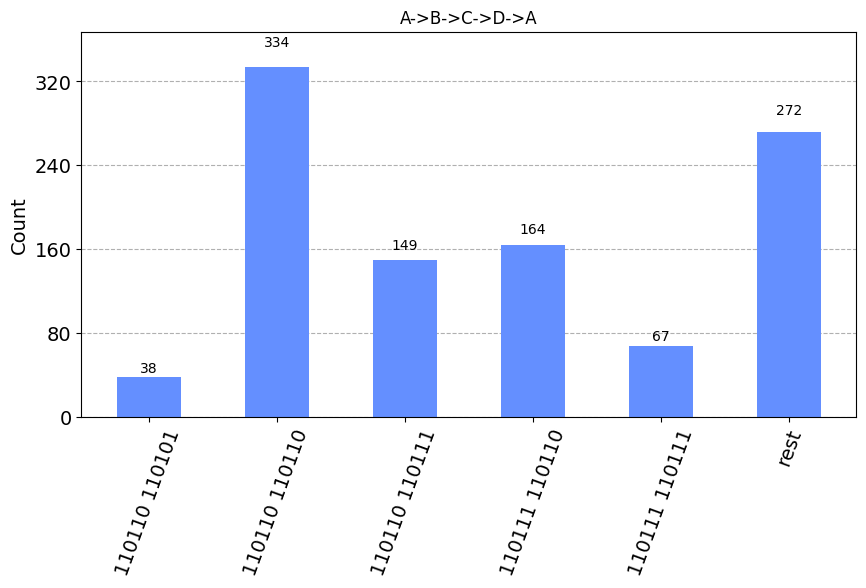

In [10]:
simulator = Aer.get_backend('qasm_simulator')
qc1 = transpile(qc1, simulator)
result = simulator.run(qc1).result()
counts = result.get_counts(qc1)
plot_histogram(counts, title='A->B->C->D->A', figsize=(10, 5), number_to_keep = 5)

In [11]:
bitstring_converter(max(counts, key=counts.get))

[0.84375, 0.84375]

In [12]:
## A->B->D->C->A 
eig = eigstatelist[1] 
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc2 = SingleHamiltonianCycle(eig, n)
qc2.draw(fold=-1)

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                         ┌───────┐ ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ░ ┌─┐                                 
     phase_0: ┤ H ├───■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├─░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├─────────────────────────────────
              ├───┤   │                                                                                                                                                                                                                                                                                                                                                                                                                                                     │       │ ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ░ └╥┘┌─┐                              
     phase_1: ┤ H ├───┼──────■──────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─░────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

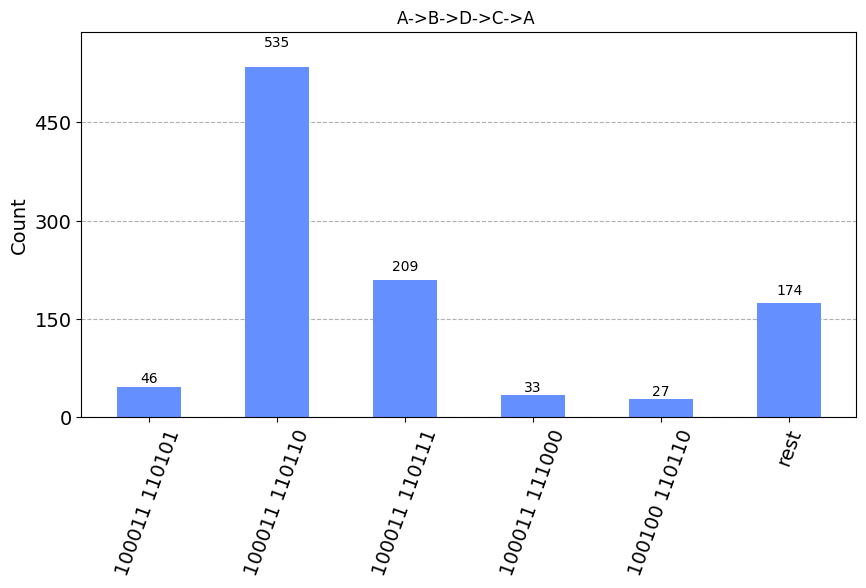

In [13]:
simulator = Aer.get_backend('qasm_simulator')
qc2 = transpile(qc2, simulator)
result = simulator.run(qc2).result()
counts = result.get_counts(qc2)
plot_histogram(counts, title='A->B->D->C->A ', figsize=(10, 5), number_to_keep = 5)

In [14]:
bitstring_converter(max(counts, key=counts.get))

[0.84375, 0.546875]

In [15]:
## A->C->B->D->A
eig = eigstatelist[2] 
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc3 = SingleHamiltonianCycle(eig, n)
qc3.draw(fold=-1)

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                         ┌───────┐ ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ░ ┌─┐                                 
     phase_0: ┤ H ├───■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├─░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├─────────────────────────────────
              ├───┤   │                                                                                                                                                                                                                                                                                                                                                                                                                                                     │       │ ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ░ └╥┘┌─┐                              
     phase_1: ┤ H ├───┼──────■──────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─░────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

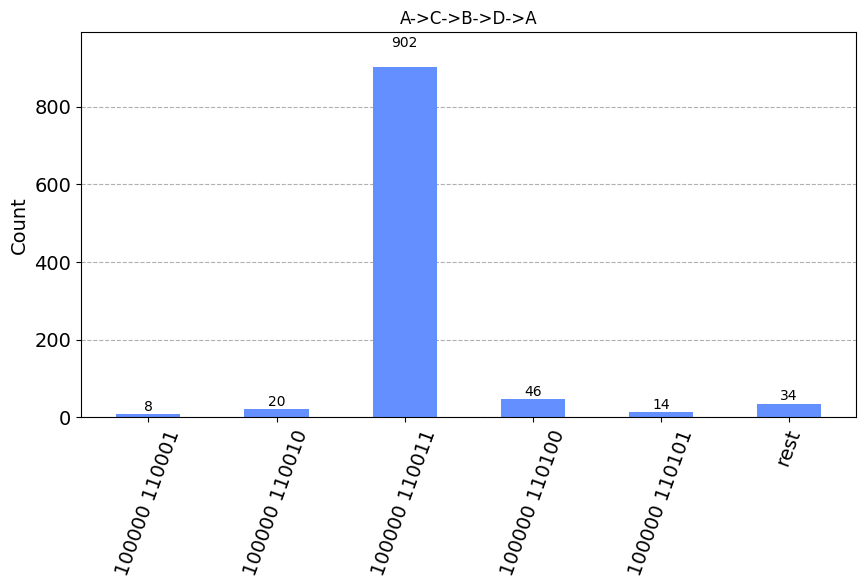

In [16]:
simulator = Aer.get_backend('qasm_simulator')
qc3 = transpile(qc3, simulator)
result = simulator.run(qc3).result()
counts = result.get_counts(qc3)
plot_histogram(counts, title='A->C->B->D->A', figsize=(10, 5), number_to_keep = 5)

In [17]:
bitstring_converter(max(counts, key=counts.get))

[0.796875, 0.5]

## Representing all Hamiltonian Cycles with Barriers

In [18]:
registers = []
c_registers = []
p_registers = []
pc_registers = []
cc_registers = []
e_registers = []

n = 5 # estimation number
for i, eig in enumerate(eigstatelist):    
    eigst   = QuantumRegister(m, name = 'eigenstate '+ str(i+1))
    phase   = QuantumRegister(n, name = 'phase ' + str(i + 1))
    phase_c = QuantumRegister(n, name = 'phase c '+ str(i + 1))
    cr      = ClassicalRegister(n, 'output '+ str(i + 1))
    cr_c    = ClassicalRegister(n, 'output c '+ str(i + 1))
    
    registers.append(phase)
    registers.append(phase_c)
    registers.append(eigst)
    registers.append(cr)
    registers.append(cr_c)
    
    p_registers.append(phase)
    pc_registers.append(phase_c)
    e_registers.append(eigst)
    c_registers.append(cr)
    cc_registers.append(cr_c)


# constructing the circuit:
qc = QuantumCircuit(*registers)

# Apply H-Gates to phase qubits:
for qubit in p_registers:
    qc.h(qubit)
    
for qubit in pc_registers:
    qc.h(qubit)
        


for eig, e_register in zip(eigstatelist, e_registers):
    
    eig = eig[::-1] # needs to be reversed
    for ind, qubit in enumerate(e_register): 
        if(int(eig[ind])):
            qc.x(qubit)

    
for i, phase in enumerate(p_registers):
    repetitions = 1 

    for qubit in phase:
        applied_qubits = np.append([qubit], [e_registers[i]])
        for j in range(repetitions):
            qc.append(CUgate, list(applied_qubits)); # This is CU
        repetitions *= 2
    
for phase in p_registers:
    qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase)

qc.barrier()

for i, phase in enumerate(pc_registers):
    repetitions = 1 

    for qubit in phase:
        applied_qubits = np.append([qubit], [e_registers[i]])
        for j in range(repetitions):
            qc.append(CUPgate, list(applied_qubits)); # This is CUP
        repetitions *= 2
    
for phase in pc_registers:
    qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase)

qc.barrier()


for phase, bits, phase2, bits2 in zip(p_registers, c_registers, pc_registers, cc_registers):
    qc.measure(phase,bits)
    qc.measure(phase2,bits2)

qc.draw(fold=-1)

┌───┐                                                                                                                                                                                                                         ┌───────┐ ░                                                                                                                                                                                                                                                                   ░ ┌─┐                                                                                       
     phase 1_0: ┤ H ├───■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├─░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├───────────────────────────────────────────────────────────────────────────────────────
                ├───┤   │                                                                                                                                                                                                                     │       │ ░                                                                                                                                                                                                                                                                   ░ └╥┘┌─┐                                                                                    
     phase 1_1: ┤ H ├───┼──────■──────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫─┤M├────────────────────────────────────────────────────────────────────────────────────
                ├───┤   │      │      │                                                                                                                                                                                                       │       │ ░                                                                                                                                                                                                                                                                   ░  ║ └╥┘┌─┐                                                                                 
     phase 1_2: ┤ H ├───┼──────┼──────┼──────■──────■──────■──────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤2 IQFT ├─░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──╫──╫─┤M├─────────────────────────────────────────────────────────────────────────────────
                ├───┤   │      │      │      │      │      │      │                                                                                                                                                                           │       │ ░                                                                                                                                                                 

In [19]:
# simulator = Aer.get_backend('qasm_simulator')
# qc = transpile(qc, simulator)
#counts = execute(qc2, backend=simulator, shots=100).result().get_counts()
#plot_histogram(counts, title='A->B->D->C->A ', figsize=(10, 5), number_to_keep = 5)

In [20]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService()
# backend = service.get_backend("simulator_mps")